In [20]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [4]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

ticker             SPY                                  TLT            \
metric             prc       ret      retx retd         prc       ret   
date                                                                    
2004-11-19  117.419998  0.988883  0.988883  0.0   88.260002  0.992020   
2004-11-22  117.980003  1.004769  1.004769  0.0   88.720001  1.005212   
2004-11-23  118.160004  1.001526  1.001526  0.0   88.830002  1.001240   
2004-11-24  118.440002  1.002370  1.002370  0.0   88.830002  1.000000   
2004-11-26  118.339996  0.999156  0.999156  0.0   88.250000  0.993471   
...                ...       ...       ...  ...         ...       ...   
2020-11-23  357.459991  1.005994  1.005994  0.0  160.770004  0.995418   
2020-11-24  363.220001  1.016114  1.016114  0.0  159.169998  0.990048   
2020-11-25  362.660004  0.998458  0.998458  0.0  158.679993  0.996921   
2020-11-27  363.670013  1.002785  1.002785  0.0  160.220001  1.009705   
2020-11-30  362.059998  0.995573  0.995573  0.0  160.020004  0.998752   

ticker                            GLD                           
metric          retx retd         prc       ret      retx retd  
date                                                            
2004-11-19  0.992020  0.0   44.779999  1.009013  1.009013  0.0  
2004-11-22  1.005212  0.0   44.950001  1.003796  1.003796  0.0  
2004-11-23  1.001240  0.0   44.750000  0.995551  0.995551  0.0  
2004-11-24  1.000000  0.0   45.049999  1.006704  1.006704  0.0  
2004-11-26  0.993471  0.0   45.290001  1.005327  1.005327  0.0  
...              ...  ...         ...       ...       ...  ...  
2020-11-23  0.995418  0.0  172.229996  0.980306  0.980306  0.0  
2020-11-24  0.990048  0.0  169.589996  0.984672  0.984672  0.0  
2020-11-25  0.996921  0.0  169.509995  0.999528  0.999528  0.0  
2020-11-27  1.009705  0.0  167.789993  0.989853  0.989853  0.0  
2020-11-30  0.998752  0.0  166.669998  0.993325  0.993325  0.0  

[4035 rows x 12 columns]

# Allocate shares

In [5]:
 
date_start = d.index[0].date().isoformat()
money = 10000000
portfolio_weights = {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
latest_prices = {'spy': d.loc[date_start]['SPY']['prc'], 'tlt': d.loc[date_start]['TLT']['prc'], \
          'gld': d.loc[date_start]['GLD']['prc']}
latest_prices = pd.Series(latest_prices)

da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=10000000)
shares, cash = da.lp_portfolio()

[0.4999978362030029, 0.4000031556816101, 0.09999821527404786]

# Set up dataframe to track trades

In [6]:
initial_df = np.array([[shares['spy'], latest_prices['spy'], -shares['spy']*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'], 0,0,
                        shares['tlt'], latest_prices['tlt'], -shares['tlt']*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'],0,0,
                        shares['gld'], latest_prices['gld'], -shares['gld']*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'],0,0]])

iterables = [['SPY', 'TLT', 'GLD'], ['shr chg', 'prc', 'csh chg', 'tot shr', 'tot bal', 'divflag', 'rebalflag']]
columns = pd.MultiIndex.from_product(iterables, names=['ticker', 'metric'])

df_trades_initial = pd.DataFrame(initial_df, columns = columns, 
                         index = [date_start])

In [7]:
df_cash_initial = pd.DataFrame(cash, columns = ['cash'], 
                         index = [date_start])

,cash
2004-11-19,7.928413


# Dataframe to track daily movements

In [10]:
iterables = [['SPY', 'TLT', 'GLD'], ['price', 'return', 'weight', 'shares', 'value']]
columns = pd.MultiIndex.from_product(iterables, names=['ticker', 'metric'])
date = []
portfolio_detail_initial = pd.DataFrame(columns=columns)

In [11]:
columns = ['total_value', 'asset_value', 'cash', 'cash_pct']


portfolio_sum_initial = pd.DataFrame(columns=columns)

# Loop to track dividend payments and rebalance every 6 months

In [13]:
rebalance_days = 126
trading_day_counter = 1
df_trades = df_trades_initial
df_cash = df_cash_initial

portfolio_detail = portfolio_detail_initial
portfolio_sum = portfolio_sum_initial

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    divflag = 0
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    latest_prices = {'spy': row['SPY']['prc'], 'tlt': row['TLT']['prc'], \
          'gld': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0


    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend

    if row['SPY']['retd'] > 0:
        divflag=1
        spy_div_cash = row['SPY']['prc']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/row['SPY']['prc'])
        leftover_cash = spy_div_cash-(new_spy_shares*row['SPY']['prc'])

    if row['TLT']['retd'] > 0:
        divflag = 1
        tlt_div_cash = row['TLT']['prc']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/row['TLT']['prc'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*row['TLT']['prc'])+leftover_cash

    if row['GLD']['retd'] > 0:
        divflag=1
        gld_div_cash = row['GLD']['prc']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/row['GLD']['prc'])
        leftover_cash = gld_div_cash-(new_gld_shares*row['GLD']['prc'])+leftover_cash

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.

    if divflag ==1:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['spy'], -new_spy_shares * latest_prices['spy'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['spy'], divflag, tradeflag,
                        new_tlt_shares, latest_prices['tlt'], -new_tlt_shares * latest_prices['tlt'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['tlt'], divflag, tradeflag,
                        new_gld_shares, latest_prices['gld'], -new_gld_shares * latest_prices['gld'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['gld'], divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0

    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.

    if trading_day_counter % rebalance_days == 0:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]


        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['spy']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['tlt']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['gld']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['spy'], -rebal_spy*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'], divflag, tradeflag,
                        rebal_tlt, latest_prices['tlt'], -rebal_tlt*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'], divflag, tradeflag,
                        rebal_gld, latest_prices['gld'], -rebal_gld*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1


    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"

    share_dic = {'spy':df_trades['SPY']['tot shr'].iloc[-1],
                 'tlt':df_trades['TLT']['tot shr'].iloc[-1],
                 'gld':df_trades['GLD']['tot shr'].iloc[-1]}

    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}

    new_port_det = np.array([[latest_prices['spy'], row["SPY"]['ret'], actual_weights["spy"], share_dic['spy'], tic_vals['spy'],
                    latest_prices['tlt'], row["TLT"]['ret'], actual_weights["tlt"], share_dic['tlt'], tic_vals['tlt'],
                    latest_prices['gld'], row["GLD"]['ret'], actual_weights["gld"], share_dic['gld'], tic_vals['gld']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))

    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])

    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))
portfolio_detail.index = d.index
portfolio_sum.index = d.index



In [325]:
threshold = .1
df_trades = df_trades_initial
df_cash = df_cash_initial

portfolio_detail = portfolio_detail_initial
portfolio_sum = portfolio_sum_initial


#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    divflag = 0
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    latest_prices = {'spy': row['SPY']['prc'], 'tlt': row['TLT']['prc'], \
          'gld': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0
    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if row['SPY']['retd'] > 0:
        divflag=1
        spy_div_cash = row['SPY']['prc']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/row['SPY']['prc'])
        leftover_cash = spy_div_cash-(new_spy_shares*row['SPY']['prc'])

    if row['TLT']['retd'] > 0:
        divflag = 1
        tlt_div_cash = row['TLT']['prc']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/row['TLT']['prc'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*row['TLT']['prc'])+leftover_cash
    
    if row['GLD']['retd'] > 0:
        divflag=1
        gld_div_cash = row['GLD']['prc']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/row['GLD']['prc'])
        leftover_cash = gld_div_cash-(new_gld_shares*row['GLD']['prc'])+leftover_cash
    
    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    
    if divflag ==1:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['spy'], -new_spy_shares * latest_prices['spy'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['spy'], divflag, tradeflag,
                        new_tlt_shares, latest_prices['tlt'], -new_tlt_shares * latest_prices['tlt'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['tlt'], divflag, tradeflag,
                        new_gld_shares, latest_prices['gld'], -new_gld_shares * latest_prices['gld'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['gld'], divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0
    
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    dev_weights = {k:abs((actual_weights[k]/portfolio_weights[k])-1) for k in actual_weights}
    
    #Checks to see if rebalancing should occur due to an asset passing the threshold. The % deviation is calculated by: 
    #
    #                       |[Actual % of portfolio] / [target % of portfolio] - 1|
    #
    #If this absolute value is greater than the threshold, rebalancing occurs. This sells all the shares and reblances 
    #using the original weights and the total value available. The share amount before rebalancing is then subtracted 
    #to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if max(dev_weights[k] for k in actual_weights) > threshold:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['spy']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['tlt']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['gld']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['spy'], -rebal_spy*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'], divflag, tradeflag,
                        rebal_tlt, latest_prices['tlt'], -rebal_tlt*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'], divflag, tradeflag,
                        rebal_gld, latest_prices['gld'], -rebal_gld*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1
    
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    share_dic = {'spy':df_trades['SPY']['tot shr'].iloc[-1],
                 'tlt':df_trades['TLT']['tot shr'].iloc[-1],
                 'gld':df_trades['GLD']['tot shr'].iloc[-1]}
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    
    new_port_det = np.array([[latest_prices['spy'], row["SPY"]['ret'], actual_weights["spy"], share_dic['spy'], tic_vals['spy'],
                    latest_prices['tlt'], row["TLT"]['ret'], actual_weights["tlt"], share_dic['tlt'], tic_vals['tlt'],
                    latest_prices['gld'], row["GLD"]['ret'], actual_weights["gld"], share_dic['gld'], tic_vals['gld']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))
    
    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])
    
    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))

portfolio_detail.index = d.index
portfolio_sum.index = d.index

In [49]:
portfolio_detail

ticker             SPY                                                    TLT  \
metric           price    return    weight   shares         value       price   
date                                                                            
2004-11-19  117.419998  0.988883  0.499998  42582.0  4.999978e+06   88.260002   
2004-11-22  117.980003  1.004769  0.499959  42582.0  5.023825e+06   88.720001   
2004-11-23  118.160004  1.001526  0.500314  42582.0  5.031489e+06   88.830002   
2004-11-24  118.440002  1.002370  0.500572  42582.0  5.043412e+06   88.830002   
2004-11-26  118.339996  0.999156  0.501403  42582.0  5.039154e+06   88.250000   
...                ...       ...       ...      ...           ...         ...   
2020-11-23  357.459991  1.005994  0.514467  60187.0  2.151444e+07  160.770004   
2020-11-24  363.220001  1.016114  0.499997  57737.0  2.097123e+07  159.169998   
2020-11-25  362.660004  0.998458  0.500252  57737.0  2.093890e+07  158.679993   
2020-11-27  363.670013  1.002785  0.499519  57737.0  2.099722e+07  160.220001   
2020-11-30  362.059998  0.995573  0.498991  57737.0  2.090426e+07  160.020004   

ticker                                                         GLD            \
metric        return    weight    shares         value       price    return   
date                                                                           
2004-11-19  0.992020  0.400003   45321.0  4.000032e+06   44.779999  1.009013   
2004-11-22  1.005212  0.400148   45321.0  4.020879e+06   44.950001  1.003796   
2004-11-23  1.001240  0.400318   45321.0  4.025865e+06   44.750000  0.995551   
2004-11-24  1.000000  0.399578   45321.0  4.025865e+06   45.049999  1.006704   
2004-11-26  0.993471  0.397964   45321.0  3.999578e+06   45.290001  1.005327   
...              ...       ...       ...           ...         ...       ...   
2020-11-23  0.995418  0.391932  101948.0  1.639018e+07  172.229996  0.980306   
2020-11-24  0.990048  0.400002  105404.0  1.677715e+07  169.589996  0.984672   
2020-11-25  0.996921  0.399589  105404.0  1.672551e+07  169.509995  0.999528   
2020-11-27  1.009705  0.401758  105404.0  1.688783e+07  167.789993  0.989853   
2020-11-30  0.998752  0.402614  105404.0  1.686675e+07  166.669998  0.993325   

ticker                                       
metric        weight   shares         value  
date                                         
2004-11-19  0.099998  22331.0  9.999822e+05  
2004-11-22  0.099894  22331.0  1.003778e+06  
2004-11-23  0.099368  22331.0  9.993122e+05  
2004-11-24  0.099849  22331.0  1.006012e+06  
2004-11-26  0.100633  22331.0  1.011371e+06  
...              ...      ...           ...  
2020-11-23  0.093601  22727.0  3.914271e+06  
2020-11-24  0.100001  24732.0  4.194300e+06  
2020-11-25  0.100159  24732.0  4.192321e+06  
2020-11-27  0.098722  24732.0  4.149782e+06  
2020-11-30  0.098395  24732.0  4.122082e+06  

[4035 rows x 15 columns]

In [50]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+07,9.999992e+06,7.928413,7.928413e-07
2004-11-22,1.004849e+07,1.004848e+07,7.928413,7.890154e-07
2004-11-23,1.005667e+07,1.005667e+07,7.928413,7.883733e-07
2004-11-24,1.007530e+07,1.007529e+07,7.928413,7.869162e-07
2004-11-26,1.005011e+07,1.005010e+07,7.928413,7.888881e-07
...,...,...,...,...
2020-11-23,4.181916e+07,4.181890e+07,266.056851,6.362080e-06
2020-11-24,4.194272e+07,4.194269e+07,35.603512,8.488603e-07
2020-11-25,4.185676e+07,4.185673e+07,35.603512,8.506036e-07


In [51]:
df_trades

ticker                   SPY                                                   \
metric               shr chg         prc       csh chg  tot shr       tot bal   
2004-11-19           42582.0  117.419998 -4.999978e+06  42582.0  4.999978e+06   
2004-12-01 00:00:00      0.0  119.230003  0.000000e+00  42582.0  5.077052e+06   
2004-12-17 00:00:00    200.0  119.440002 -2.388800e+04  42782.0  5.109882e+06   
2004-12-31 00:00:00      0.0  120.870003  0.000000e+00  42782.0  5.171060e+06   
2005-02-01 00:00:00      0.0  118.910004  0.000000e+00  42782.0  5.087208e+06   
...                      ...         ...           ...      ...           ...   
2020-09-01 00:00:00      0.0  352.600006  0.000000e+00  59948.0  2.113767e+07   
2020-09-18 00:00:00    239.0  330.649994 -7.902535e+04  60187.0  1.990083e+07   
2020-10-01 00:00:00      0.0  337.040009  0.000000e+00  60187.0  2.028543e+07   
2020-11-02 00:00:00      0.0  330.200012  0.000000e+00  60187.0  1.987375e+07   
2020-11-24 00:00:00  -2450.0  363.220001  8.898890e+05  57737.0  2.097123e+07   

ticker                                     TLT                            ...  \
metric              divflag rebalflag  shr chg         prc       csh chg  ...   
2004-11-19              0.0       0.0  45321.0   88.260002 -4.000032e+06  ...   
2004-12-01 00:00:00     1.0       0.0    184.0   86.449997 -1.590680e+04  ...   
2004-12-17 00:00:00     1.0       0.0      0.0   88.750000  0.000000e+00  ...   
2004-12-31 00:00:00     1.0       0.0    172.0   88.550003 -1.523060e+04  ...   
2005-02-01 00:00:00     1.0       0.0    171.0   91.220001 -1.559862e+04  ...   
...                     ...       ...      ...         ...           ...  ...   
2020-09-01 00:00:00     1.0       0.0    114.0  163.860001 -1.868004e+04  ...   
2020-09-18 00:00:00     1.0       0.0      0.0  163.570007  0.000000e+00  ...   
2020-10-01 00:00:00     1.0       0.0    105.0  163.360001 -1.715280e+04  ...   
2020-11-02 00:00:00     1.0       0.0    109.0  158.580002 -1.728522e+04  ...   
2020-11-24 00:00:00     0.0       1.0   3456.0  159.169998 -5.500915e+05  ...   

ticker                                                   GLD              \
metric                    tot bal divflag rebalflag  shr chg         prc   
2004-11-19           4.000032e+06     0.0       0.0  22331.0   44.779999   
2004-12-01 00:00:00  3.933907e+06     1.0       0.0      0.0   45.380001   
2004-12-17 00:00:00  4.038569e+06     1.0       0.0      0.0   44.189999   
2004-12-31 00:00:00  4.044698e+06     1.0       0.0      0.0   43.799999   
2005-02-01 00:00:00  4.182255e+06     1.0       0.0      0.0   42.099998   
...                           ...     ...       ...      ...         ...   
2020-09-01 00:00:00  1.667013e+07     1.0       0.0      0.0  185.050003   
2020-09-18 00:00:00  1.664063e+07     1.0       0.0      0.0  183.199997   
2020-10-01 00:00:00  1.663642e+07     1.0       0.0      0.0  178.699997   
2020-11-02 00:00:00  1.616691e+07     1.0       0.0      0.0  177.910004   
2020-11-24 00:00:00  1.677715e+07     0.0       1.0   2005.0  169.589996   

ticker                                                                       
metric                     csh chg  tot shr       tot bal divflag rebalflag  
2004-11-19          -999982.152740  22331.0  9.999822e+05     0.0       0.0  
2004-12-01 00:00:00       0.000000  22331.0  1.013381e+06     1.0       0.0  
2004-12-17 00:00:00       0.000000  22331.0  9.868069e+05     1.0       0.0  
2004-12-31 00:00:00       0.000000  22331.0  9.780978e+05     1.0       0.0  
2005-02-01 00:00:00       0.000000  22331.0  9.401351e+05     1.0       0.0  
...                            ...      ...           ...     ...       ...  
2020-09-01 00:00:00       0.000000  22727.0  4.205631e+06     1.0       0.0  
2020-09-18 00:00:00       0.000000  22727.0  4.163586e+06     1.0       0.0  
2020-10-01 00:00:00       0.000000  22727.0  4.061315e+06     1.0       0.0  
2020-11-02 00:00:00       0.000000  22727.0  

## Analysis of Returns

This is done for Threshold Rebalancing

### Compaison of underlying assets

In [25]:
portfolio_cumret = portfolio_sum.total_value/money
spy_cum_ret = d.SPY.ret.cumprod()
gld_cum_ret = d.GLD.ret.cumprod()
tlt_cum_ret = d.TLT.ret.cumprod()

In [19]:
portfolio_sum.total_value/money

0    1.000000
0    1.004849
0    1.005667
0    1.007530
0    1.005011
       ...   
0    4.181916
0    4.194272
0    4.185676
0    4.203486
0    4.189312
Name: total_value, Length: 4035, dtype: float64

In [26]:
cum_ret = pd.DataFrame(np.array([list(portfolio_cumret), list(spy_cum_ret), list(gld_cum_ret), list(tlt_cum_ret)]).T, columns = ['portfolio', 'spy', 'gld', 'tlt'], index = portfolio_detail.index)

In [27]:
cum_ret

,portfolio,spy,gld,tlt
date,,,,
2004-11-19,1.000000,0.988883,1.009013,0.992020
2004-11-22,1.004849,0.993600,1.012844,0.997190
2004-11-23,1.005667,0.995115,1.008337,0.998426
2004-11-24,1.007530,0.997474,1.015097,0.998426
2004-11-26,1.005011,0.996631,1.020505,0.991907
...,...,...,...,...
2020-11-23,4.181916,4.146188,3.880802,3.067622
2020-11-24,4.194272,4.212999,3.821316,3.037092
2020-11-25,4.185676,4.206503,3.819513,3.027743


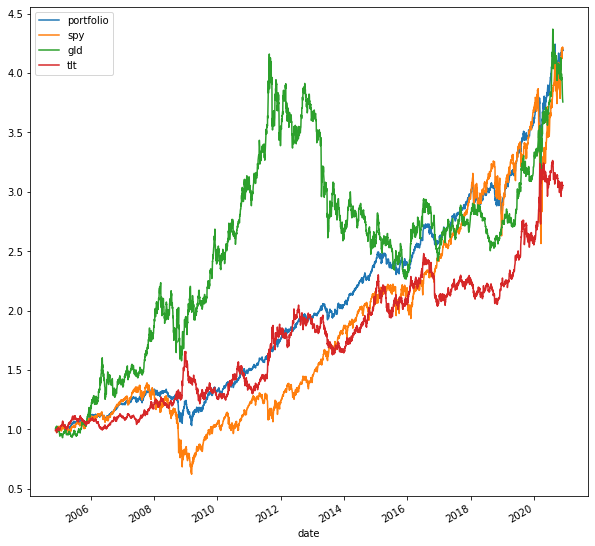

In [28]:
cum_ret.plot(figsize = (10,10))

In [36]:
port=  np.array([d.SPY.ret,d.TLT.ret, d.GLD.ret]).T

In [37]:
port

array([[0.98888328, 0.99201979, 1.00901302],
       [1.00476925, 1.00521186, 1.00379638],
       [1.00152568, 1.00123986, 0.99555059],
       ...,
       [0.99845824, 0.9969215 , 0.99952826],
       [1.002785  , 1.00970512, 0.9898531 ],
       [0.99557287, 0.99875174, 0.99332502]])

### Comparison between an untouched portfolio and a rebalanced portfolio

In [38]:
portfolio_weights = np.array([.5, .4, .1])

In [39]:
port_ret = np.matmul(port, portfolio_weights)

In [40]:
port_ret.T.shape

(4035,)

In [41]:
df_port_ret = pd.DataFrame([port_ret, cum_ret['portfolio']]).T

In [42]:
df_port_ret.columns = ['untouched_port', 'rebal_port']

In [43]:
df_port_ret['untouched_port'] = df_port_ret['untouched_port'].cumprod()

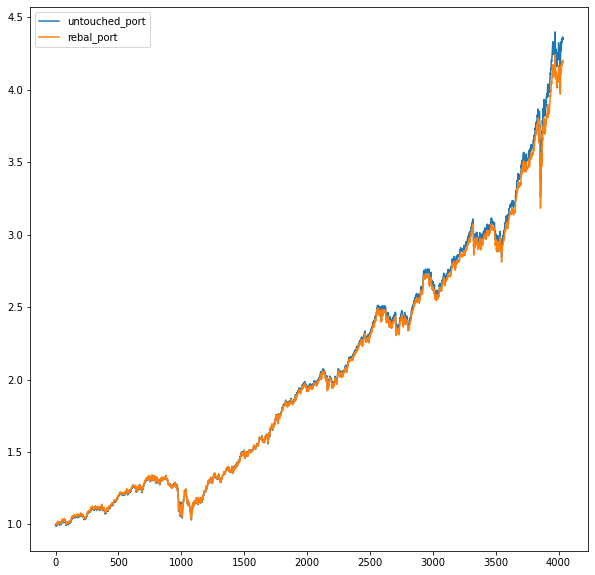

In [44]:
df_port_ret.plot(figsize = (10,10))

In [48]:
df_port_ret

,untouched_port,rebal_port
0,0.992151,1.000000
1,0.996962,1.004849
2,0.997773,1.005667
3,0.999624,1.007530
4,0.997124,1.005011
...,...,...
4030,4.344175,4.181916
4031,4.355223,4.194272
4032,4.346297,4.185676
4033,4.364811,4.203486


In [47]:
200*1.1**16

918.9945972714444